# Geomorphological Characteristics

Following the watershed delineation in previous notebook [8_waterhsed_delineation](notebooks/preprocessing/8_waterhsed_delineation.ipynb), a comprehensive suite of geomorphological parameters, as identified for this study (e.g., Area, Basin Length, Drainage Density, Relief Ratio, Form Factor, etc.), will be systematically derived for each delineated watershed using the DEM and the delineated boundaries. These quantitative descriptors of basin physiography are essential outputs of this notebook, forming the independent variables dataset that will be used to train the machine learning models for predicting ModClark parameters ($T_c$ and $R$).

In [92]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
import json
from plotnine import *
import random
from tqdm.notebook import tqdm
from shapely.geometry import MultiPolygon, Polygon


In [24]:
# Set paths
project_root_path = Path.cwd().parent.parent
wsdir = project_root_path / 'data/silver/geo/gpkg/watersheds'

## Exploratory Data Analysis

In [25]:
ws_file_path = list(wsdir.glob('*.gpkg'))
print(f'Number of delineated watersheds: {len(ws_file_path)}')

Number of delineated watersheds: 690


In [33]:
# Analysis delineated watersheds
ws_df = pd.DataFrame()
# Read all watersheds
for ws_path in tqdm(ws_file_path, desc='Reading watersheds'):
    gdf = gpd.read_file(ws_path)
    keep_columns = ['stnid', 'area', 'distance_between_points_m',]
    df = gdf[keep_columns]

    ws_df = pd.concat([ws_df, df], ignore_index=True)
    
ws_df.head()


Reading watersheds:   0%|          | 0/690 [00:00<?, ?it/s]

,stnid,area,distance_between_points_m
0,03314000,96.740342,19.884212
1,03431060,14.758231,19.955516
2,03083500,36.482751,97.648123
3,03072000,1.826379,61.664518
4,03400785,1.563727,2259.562650


In [34]:
ws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   stnid                      690 non-null    object 
 1   area                       690 non-null    float64
 2   distance_between_points_m  690 non-null    float64
dtypes: float64(2), object(1)
memory usage: 16.3+ KB


In [45]:
# Frequency table for distance_between_points_m
distance_bins = [0, 20, 100, 500, 1000, float('inf')]
distance_labels = ['0-20m', '21-100m', '101-500m', '501-1000m', '>1000m']

ws_df['distance_category'] = pd.cut(
    ws_df['distance_between_points_m'],
    bins=distance_bins,
    labels=distance_labels,
    right=True,
    include_lowest=True
)

distance_freq = ws_df['distance_category'].value_counts().sort_index()

print("Frequency Table for Distance Between Points (m):")
print(distance_freq)


Frequency Table for Distance Between Points (m):
distance_category
0-20m        214
21-100m      174
101-500m     141
501-1000m     36
>1000m       125
Name: count, dtype: int64


In [47]:

# Frequency table for area
area_bins = [0, 1.8, 5, 10, 20, 50, 80, float('inf')]
area_labels = ['<1.8 km²', '1.8-5 km²', '5.1-10 km²', '10.1-20 km²', '20.1-50 km²', '50.1-80 km²', '>80 km²']

ws_df['area_category'] = pd.cut(
    ws_df['area'],
    bins=area_bins,
    labels=area_labels,
    right=True,
    include_lowest=True
)

area_freq = ws_df['area_category'].value_counts().sort_index()

print("\nFrequency Table for Area (km²):")
print(area_freq)



Frequency Table for Area (km²):
area_category
<1.8 km²       248
1.8-5 km²      132
5.1-10 km²      64
10.1-20 km²     53
20.1-50 km²     72
50.1-80 km²     48
>80 km²         73
Name: count, dtype: int64


In [48]:
# Convert area frequency to DataFrame
area_freq_df = ws_df['area_category'].value_counts().sort_index().reset_index()
area_freq_df.columns = ['area_category', 'count']

# Convert distance frequency to DataFrame
distance_freq_df = ws_df['distance_category'].value_counts().sort_index().reset_index()
distance_freq_df.columns = ['distance_category', 'count']

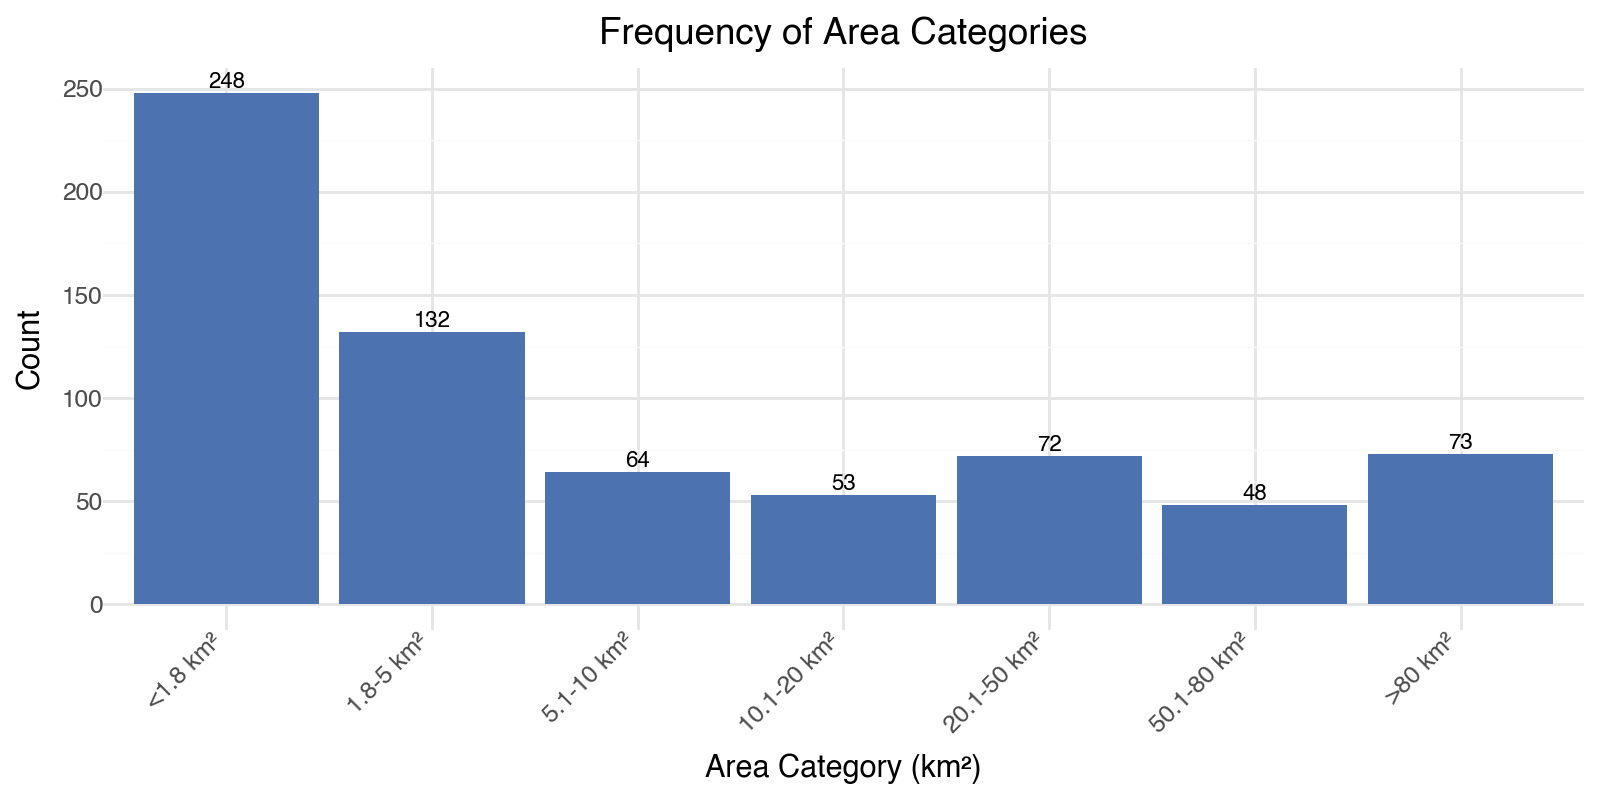

In [50]:
area_plot = (
    ggplot(area_freq_df, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#4C72B0") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

area_plot.show()


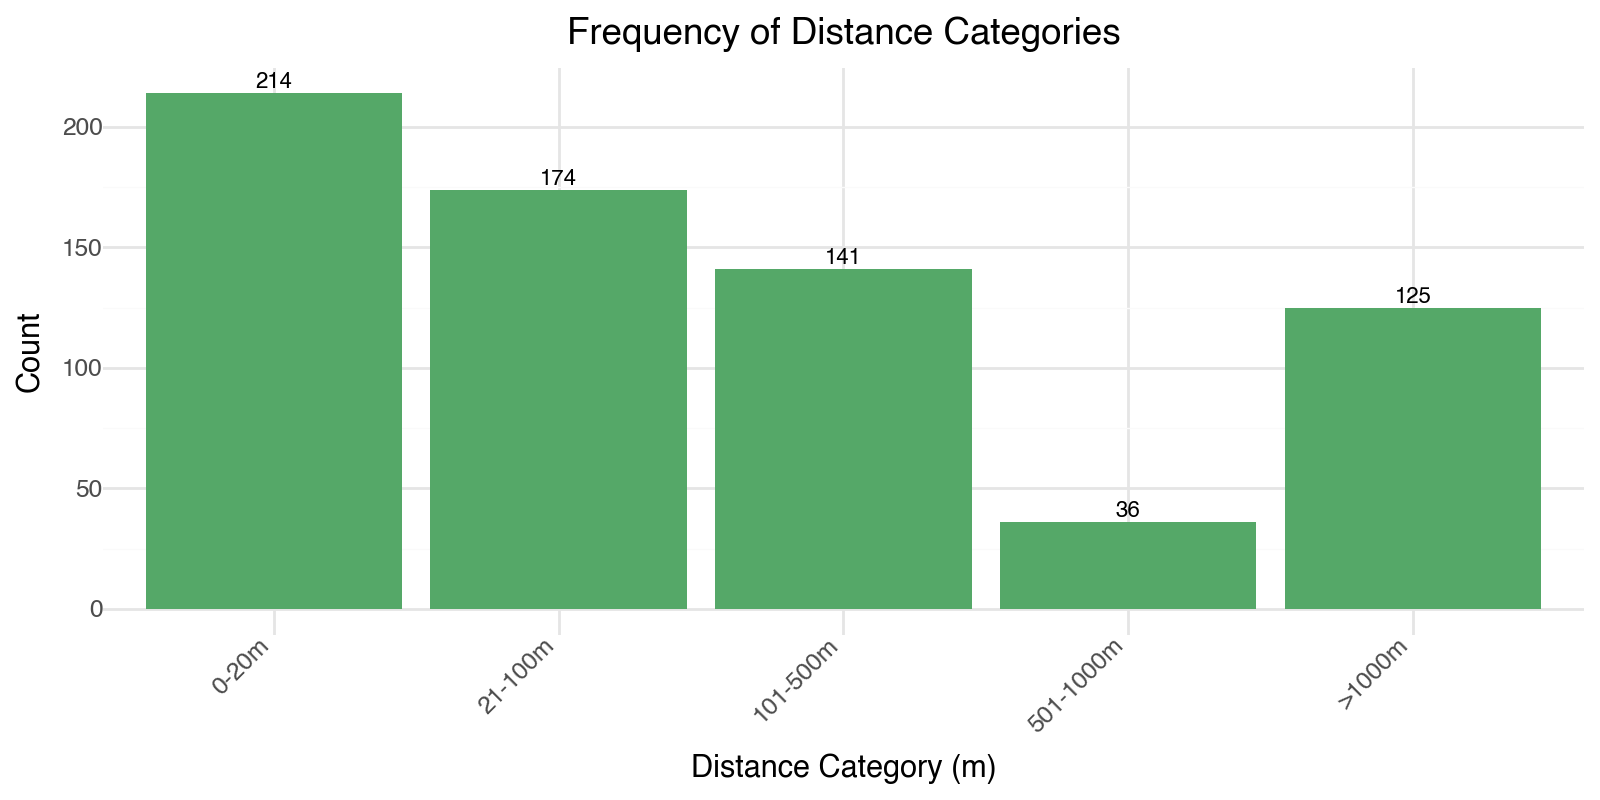

In [51]:
distance_plot = (
    ggplot(distance_freq_df, aes(x='distance_category', y='count')) +
    geom_bar(stat='identity', fill="#55A868") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Distance Categories',
        x='Distance Category (m)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

distance_plot.show()


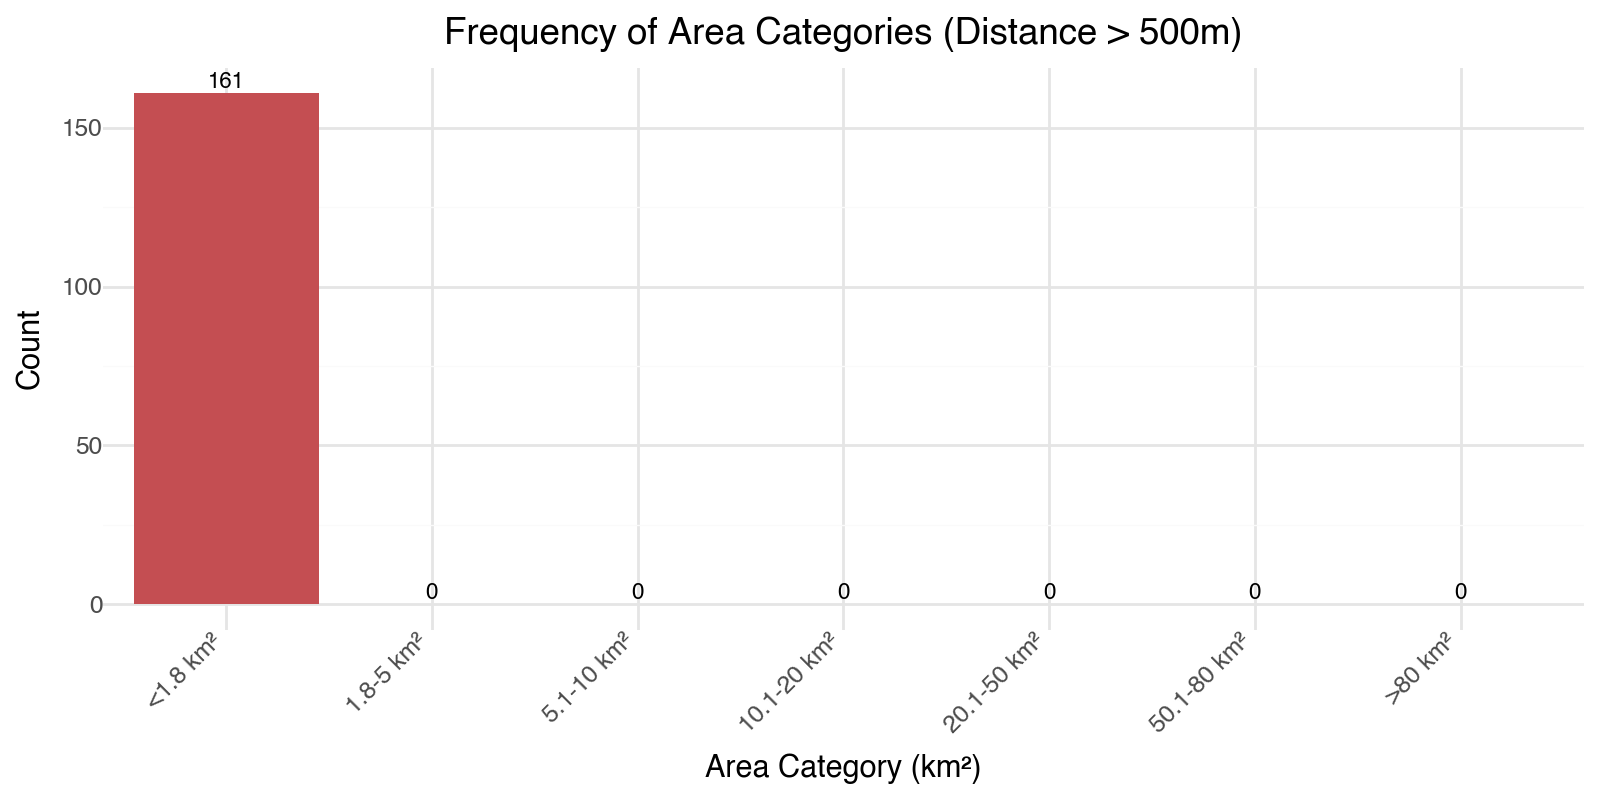

In [53]:
filtered_df = ws_df[ws_df['distance_between_points_m'] > 500]
filtered_area_freq_df = filtered_df['area_category'].value_counts().sort_index().reset_index()
filtered_area_freq_df.columns = ['area_category', 'count']

filtered_area_plot = (
    ggplot(filtered_area_freq_df, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#C44E52") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories (Distance > 500m)',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

filtered_area_plot.show()


From above, distance decreases when increasing area. It makes sense, because greater watershed area will have higher accumulation ceel value on outlet being easier to spot. Also greater area better disolves noisy data. 

Still froma above all delineation that faield on distance criteria, also failed on the area creteria. 

The procedure is to drop those stations. 

### Drop Failed Stations

In [55]:
# Drop failed stations
valid_wsb = ws_df[ws_df['distance_between_points_m']<=500]
print(f'Number of valid watersheds: {len(valid_wsb)}')


Number of valid watersheds: 529


A total of **529** Valid stations will proceed to parameters modelings.

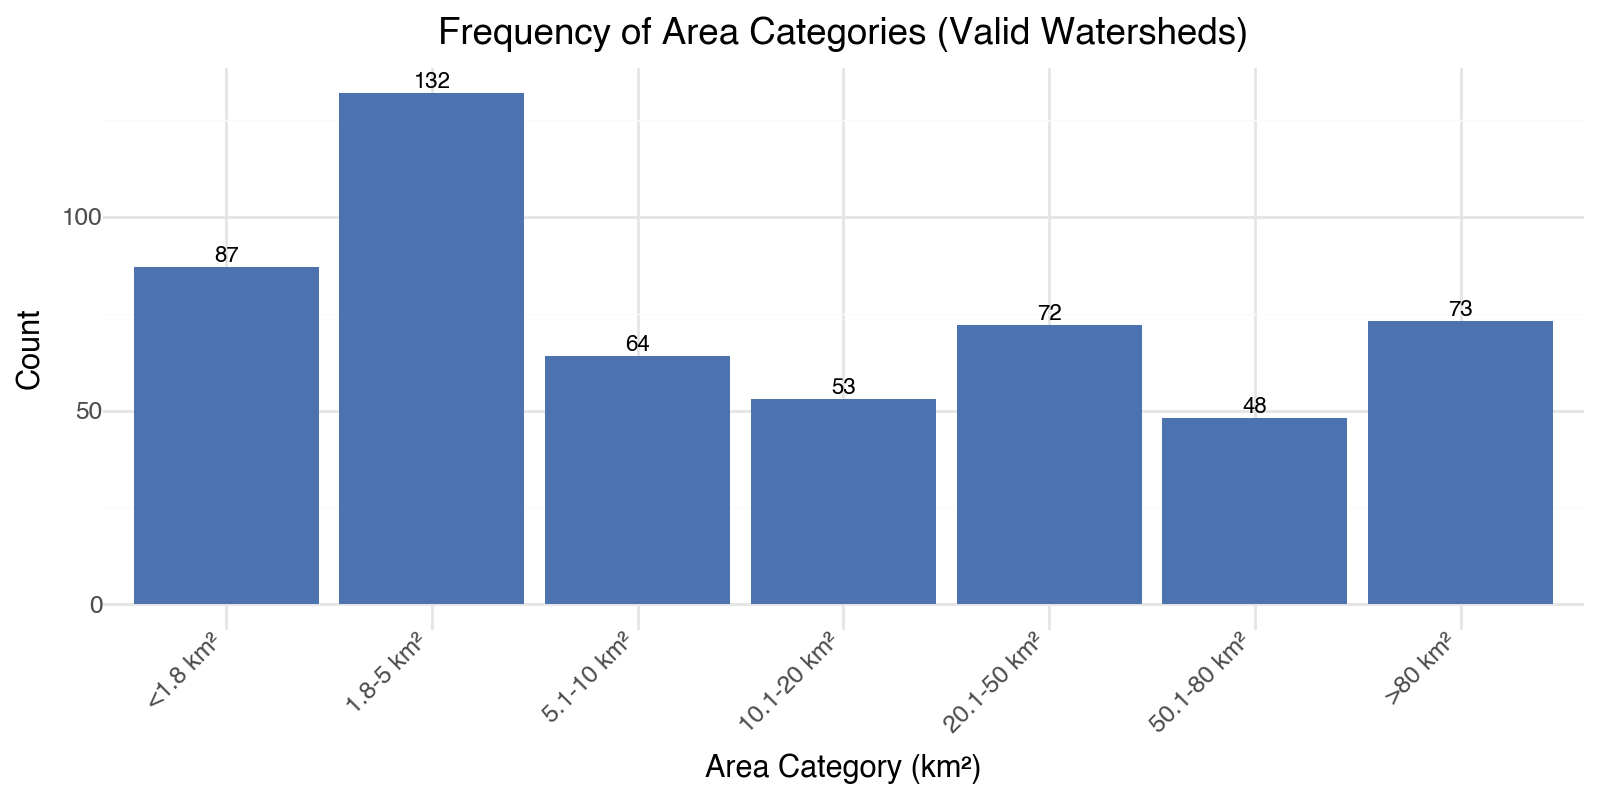

In [57]:
valid_wsb_freq = valid_wsb['area_category'].value_counts().sort_index().reset_index()
valid_wsb_freq.columns = ['area_category', 'count']

area_plot = (
    ggplot(valid_wsb_freq, aes(x='area_category', y='count')) +
    geom_bar(stat='identity', fill="#4C72B0") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Area Categories (Valid Watersheds)',
        x='Area Category (km²)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

area_plot.show()

Still **87** station with smaller than 1.8km² remains on data. Lets take a look at their distances.

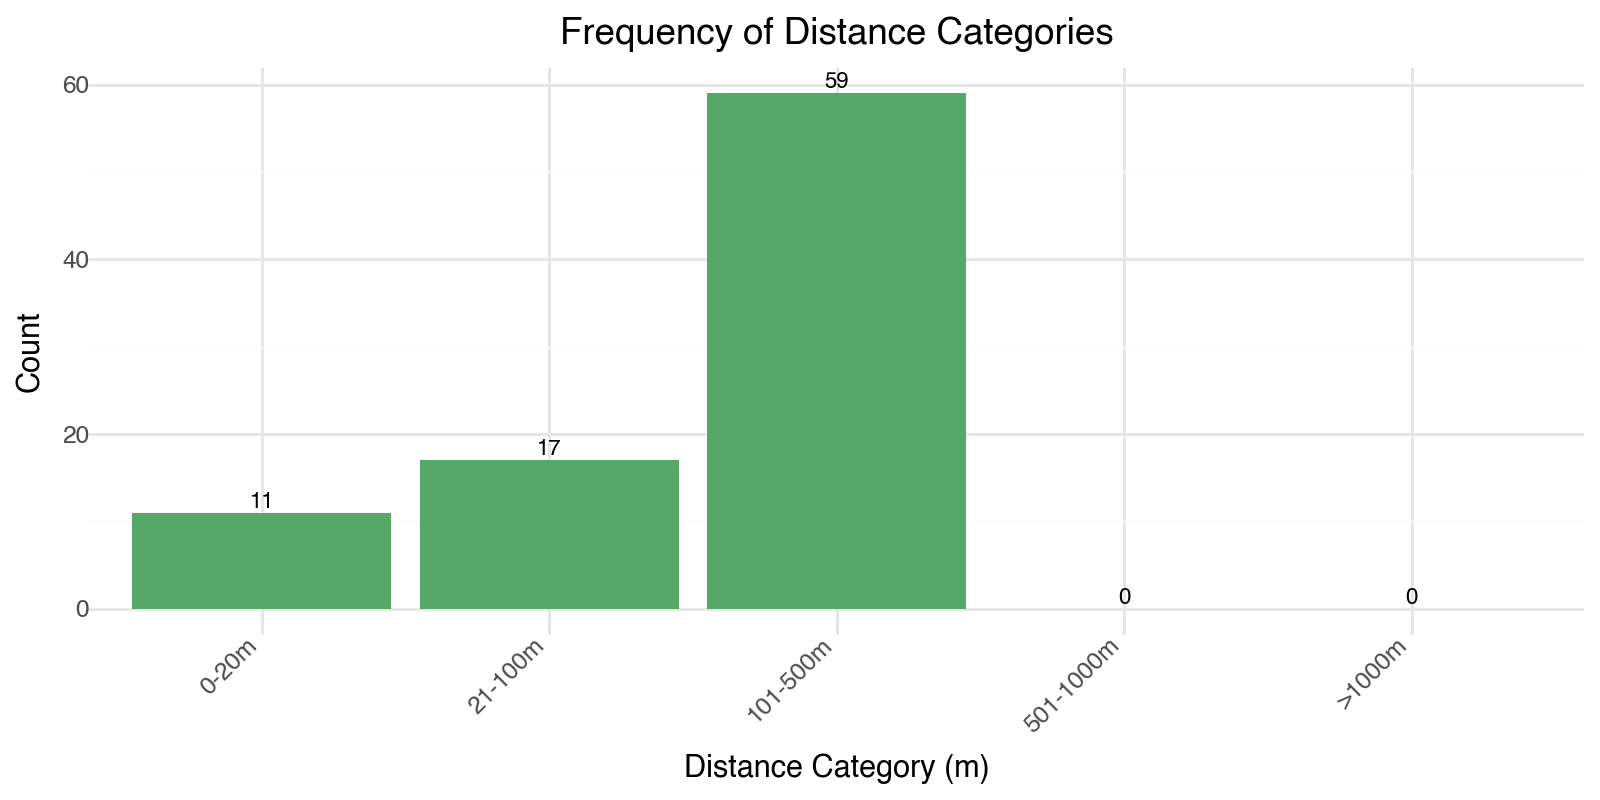

In [59]:
small_areas_df = valid_wsb[valid_wsb['area'] < 1.8]
small_areas_freq_df = small_areas_df['distance_category'].value_counts().sort_index().reset_index()
small_areas_freq_df.columns = ['distance_category', 'count']
distance_plot = (
    ggplot(small_areas_freq_df, aes(x='distance_category', y='count')) +
    geom_bar(stat='identity', fill="#55A868") +
    geom_text(aes(label='count'), va='bottom', size=8, format_string='{}') +
    theme_minimal() +
    labs(
        title='Frequency of Distance Categories',
        x='Distance Category (m)',
        y='Count'
    ) +
    theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        figure_size=(8, 4)
    )
)

distance_plot.show()


In [64]:
small_areas_df['distance_category'].unique()

['101-500m', '0-20m', '21-100m']
Categories (5, object): ['0-20m' < '21-100m' < '101-500m' < '501-1000m' < '>1000m']

The most of remaing small area watersheds, have distance between original pour point and snapped pour point greater than 100. Those watersheds will be kept in the optmization process and analysed before including them in the machine learning models. If they result in outlier in the optmization process, they will be dropped from further analysis. 

## Dataset Cleaning

Before proceeding to computing geomorphological characteristics, a cleaning process will be perfomed, to dissolve anomolies in geometries.

In [26]:
# Load style configuration for maps
map_style_path = project_root_path / 'config' / 'map_style.json'
with open(map_style_path, 'r') as f:
    map_style = json.load(f).get('map_styles',[])
    
wsb_style = map_style.get('watershed_boundary')


In [60]:
# Function to print watershed boundary and information
def create_watershed_map(ws_gdf, wsb_style):
    
    # Extract pour point and snapped pour point from string to geometry (in NAD83, EPSG:4269)
    ws_gdf['pour_point_geom'] = gpd.GeoSeries.from_wkt(ws_gdf['pour_point_nad83'], crs='EPSG:4269')
    ws_gdf['snapped_pour_point_geom'] = gpd.GeoSeries.from_wkt(ws_gdf['snapped_pour_point_nad83'], crs='EPSG:4269')
    
    # Project pour points to the CRS of ws_gdf
    pour_points = gpd.GeoDataFrame(
        {
            'geometry': [ws_gdf['pour_point_geom'].iloc[0], ws_gdf['snapped_pour_point_geom'].iloc[0]],
            'point_type': ['Pour Point', 'Snapped Pour Point']
        },
        crs='EPSG:4269'
    )
    pour_points = pour_points.to_crs(ws_gdf.crs)
    
    # Prepare text annotation for area and distance
    area = ws_gdf['area'].iloc[0]
    distance = ws_gdf['distance_between_points_m'].iloc[0]
    annotation_text = f"Area: {area:.2f} km²\nDistance: {distance:.2f} m"
    
    # Create the map
    wsb_map = (
        ggplot()
        + geom_map(
            mapping=aes(geometry='geometry'),
            data=ws_gdf,
            inherit_aes=False,
            color=wsb_style.get('color'),
            fill=None
        )
        + geom_point(
            mapping=aes(x=pour_points.geometry.x, y=pour_points.geometry.y, color='point_type'),
            data=pour_points,
            size=3,
            inherit_aes=False
        )
        + scale_color_manual(
            values={'Pour Point': 'red', 'Snapped Pour Point': 'blue'},
            name='Point Type'
        )
        + annotate(
            'text',
            x=float(ws_gdf.bounds.maxx.iloc[0] - 10),
            y=float(ws_gdf.bounds.maxy.iloc[0] - 10),
            label=annotation_text,
            size=10,
            ha='right',
            va='top'
        )
        + coord_fixed()
        + theme_minimal()
        + theme(
            legend_position='bottom',
            panel_grid_major=None,
            panel_grid_minor=None
        )
        + labs(
            title=f"Watershed boundary for station {ws_gdf.at[0, 'stnid']}",
            x="Easting",
            y="Northing"
        )
    )
    
    # Display the map
    wsb_map.show()

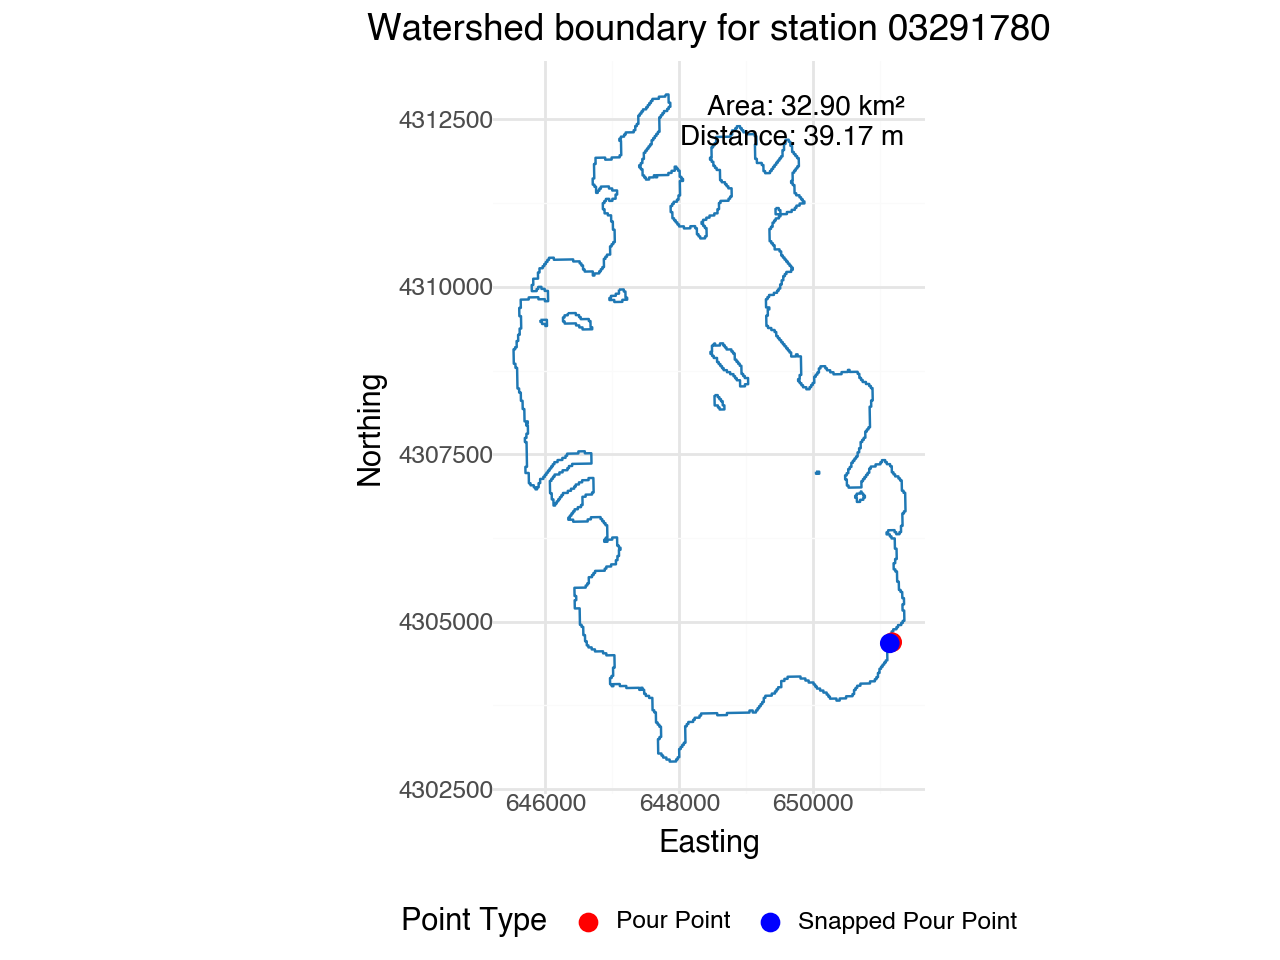

In [61]:
ws = gpd.read_file(ws_file_path[random.randint(0, len(ws_file_path)-1)])
create_watershed_map(ws, wsb_style)


52.965218943127276


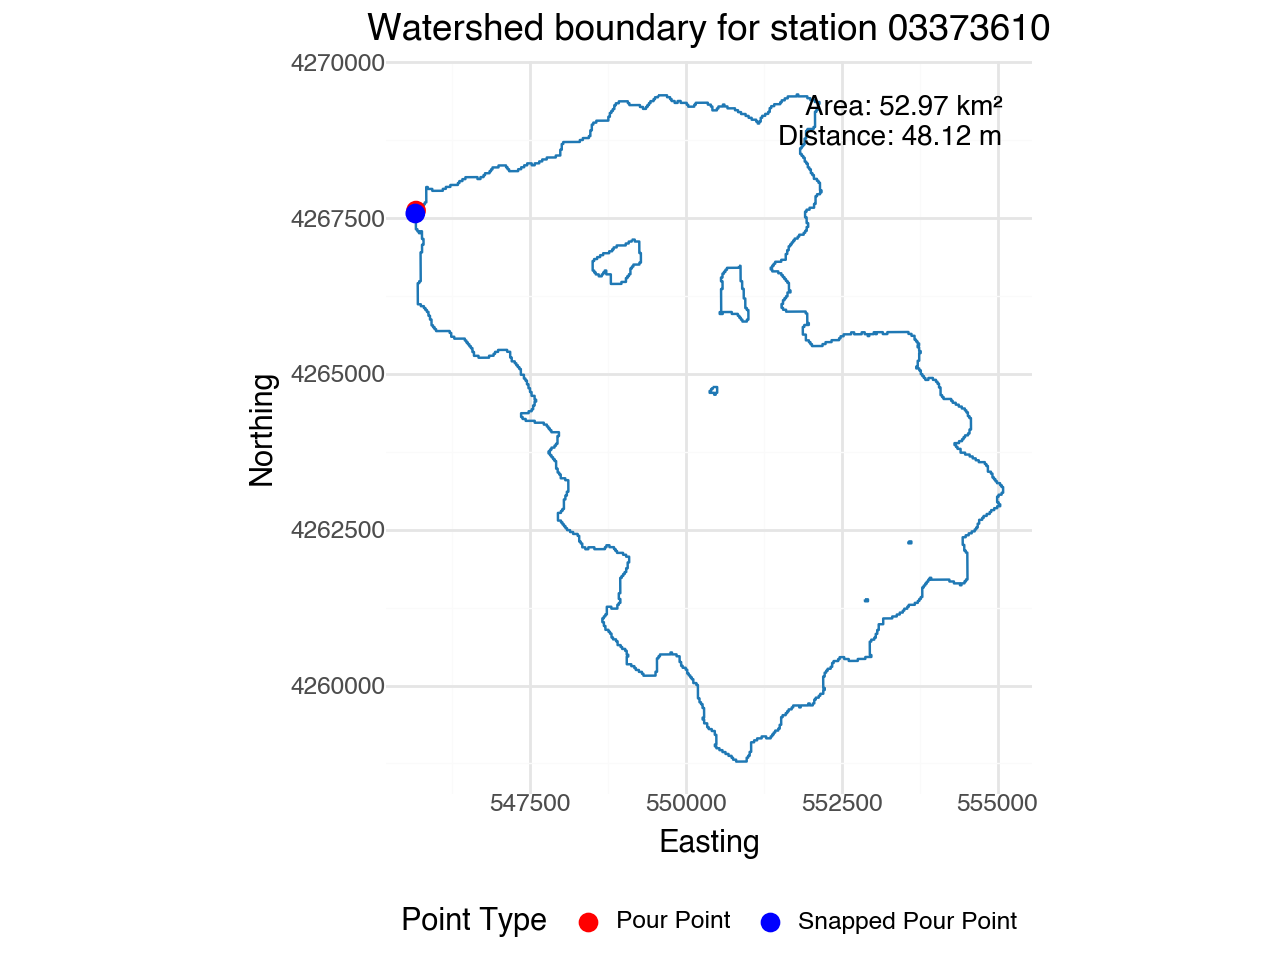

In [101]:
ws = gpd.read_file(ws_file_path[random.randint(0, len(ws_file_path)-1)])
print(ws.geometry.area.iloc[0] / 1e6)
create_watershed_map(ws, wsb_style)

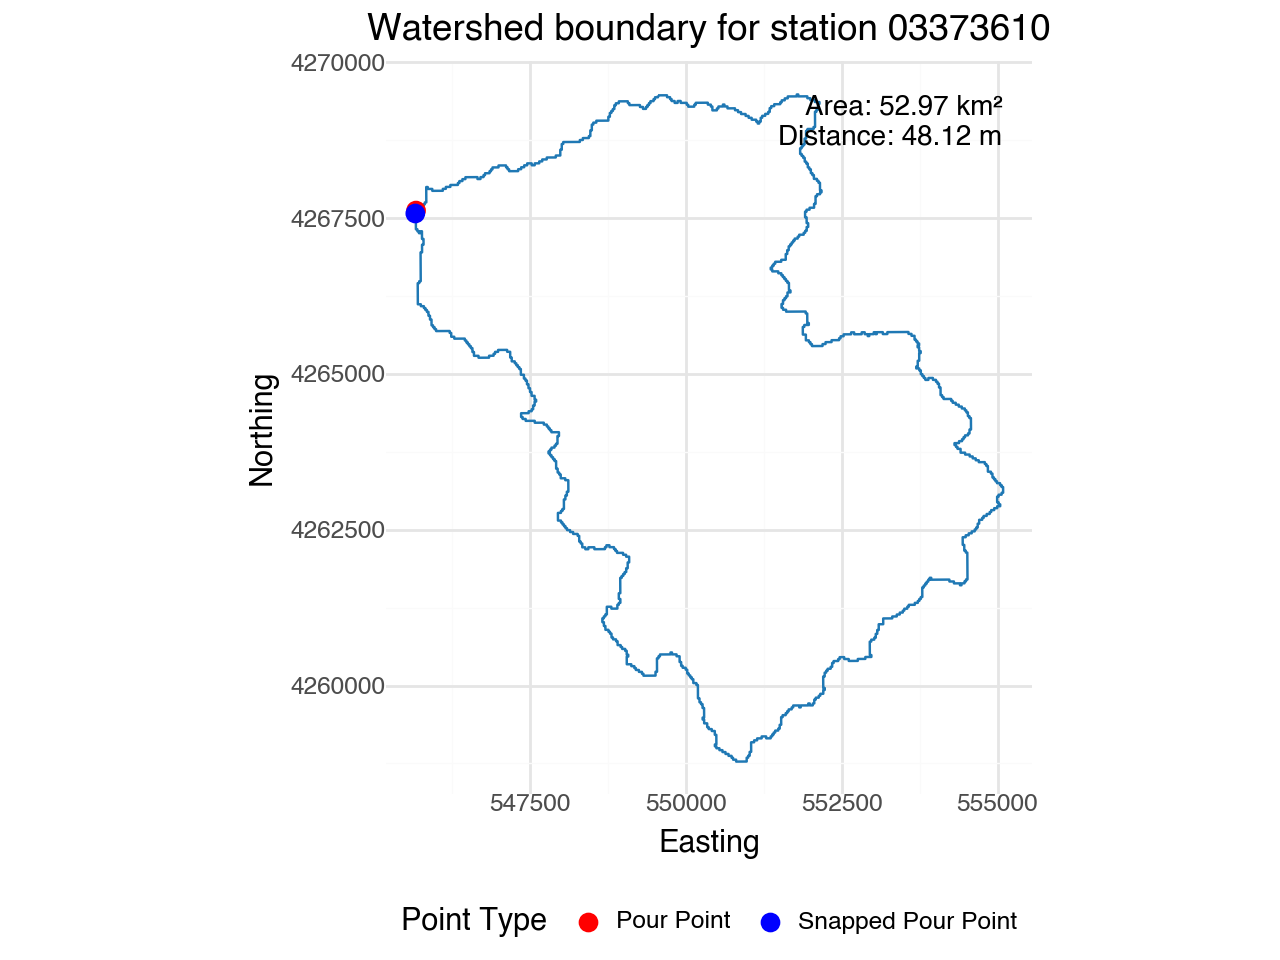

In [102]:
def clean_watershed_gdf(gdf, keep_all_parts=False):
    """
    Cleans a watershed GeoDataFrame by removing interior rings (holes) and optionally simplifying MultiPolygons.

    Parameters:
    -----------
    gdf : geopandas.GeoDataFrame
        GeoDataFrame containing the watershed geometry. Must have exactly one row.

    keep_all_parts : bool, default False
        - If False: keeps only the largest polygon part from a MultiPolygon.
        - If True: keeps all polygon parts, but removes interior rings from each.

    Returns:
    --------
    geopandas.GeoDataFrame
        A new GeoDataFrame with the cleaned geometry.
    """
    
    if len(gdf) != 1:
        raise ValueError("GeoDataFrame must contain exactly one row.")

    # Access the geometry
    geom = gdf.geometry.iloc[0]

    # Process based on geometry type
    if isinstance(geom, MultiPolygon):
        if keep_all_parts:
            # Remove holes from all parts
            cleaned_parts = [Polygon(part.exterior) for part in geom.geoms]
            clean_geom = MultiPolygon(cleaned_parts)
        else:
            # Keep only largest part, remove its holes
            largest = max(geom.geoms, key=lambda p: p.area)
            clean_geom = Polygon(largest.exterior)
    elif isinstance(geom, Polygon):
        # Remove holes
        clean_geom = Polygon(geom.exterior)
    else:
        raise TypeError(f"Unsupported geometry type: {type(geom)}")

    # Create a copy of the GeoDataFrame
    cleaned_gdf = gdf.copy()
    cleaned_gdf.at[cleaned_gdf.index[0], 'geometry'] = clean_geom

    return cleaned_gdf


In [104]:
gdf.geometry.area.iloc[0]/ 1e6

np.float64(53.57035027827685)

In [ ]:
import geopandas as gpd
from shapely.geometry import MultiPolygon, Polygon

def clean_watershed_geometry(gpkg_path, output_path=None, keep_all_parts=False):
    """
    Cleans a watershed geometry by removing interior rings (holes) and optionally simplifying MultiPolygons.

    Parameters:
    -----------
    gpkg_path : str
        Path to the input GeoPackage (.gpkg) file containing the watershed geometry.

    output_path : str, optional
        Path to save the cleaned GeoPackage. If None, overwrites the input file.

    keep_all_parts : bool, default False
        - If False: keeps only the largest polygon part from a MultiPolygon.
        - If True: keeps all polygon parts, but removes interior rings from each.

    Returns:
    --------
    None
        The cleaned GeoPackage is saved to `output_path` or overwrites `gpkg_path`.
    """
    
    # Load the GeoPackage
    gdf = gpd.read_file(gpkg_path)

    # Access the geometry
    geom = gdf.geometry.iloc[0]

    # Process based on geometry type
    if isinstance(geom, MultiPolygon):
        if keep_all_parts:
            # Remove holes from all parts
            cleaned_parts = [Polygon(part.exterior) for part in geom.geoms]
            clean_geom = MultiPolygon(cleaned_parts)
        else:
            # Keep only largest part, remove its holes
            largest = max(geom.geoms, key=lambda p: p.area)
            clean_geom = Polygon(largest.exterior)
    elif isinstance(geom, Polygon):
        # Remove holes
        clean_geom = Polygon(geom.exterior)
    else:
        raise TypeError(f"Unsupported geometry type: {type(geom)}")

    # Replace geometry
    gdf.at[0, 'geometry'] = clean_geom

    # Determine output path
    if output_path is None:
        output_path = gpkg_path

    # Save cleaned GeoPackage
    gdf.to_file(output_path, driver='GPKG')

    print(f"Cleaned geometry saved to: {output_path}")


stnid                                                                 03335000
area                                                          124112553.750436
pour_point_nad83                  POINT (-86.82917835810188 40.44059289631946)
snapped_pour_point_nad83          POINT (-86.82931349320582 40.44072803143386)
distance_between_points_m                                             18.87702
accumulation_value                                                          50
geometry                     MULTIPOLYGON (((518948.56939270167 4468590.469...
pour_point_geom                   POINT (-86.82917835810188 40.44059289631946)
snapped_pour_point_geom           POINT (-86.82931349320582 40.44072803143386)
Name: 0, dtype: object

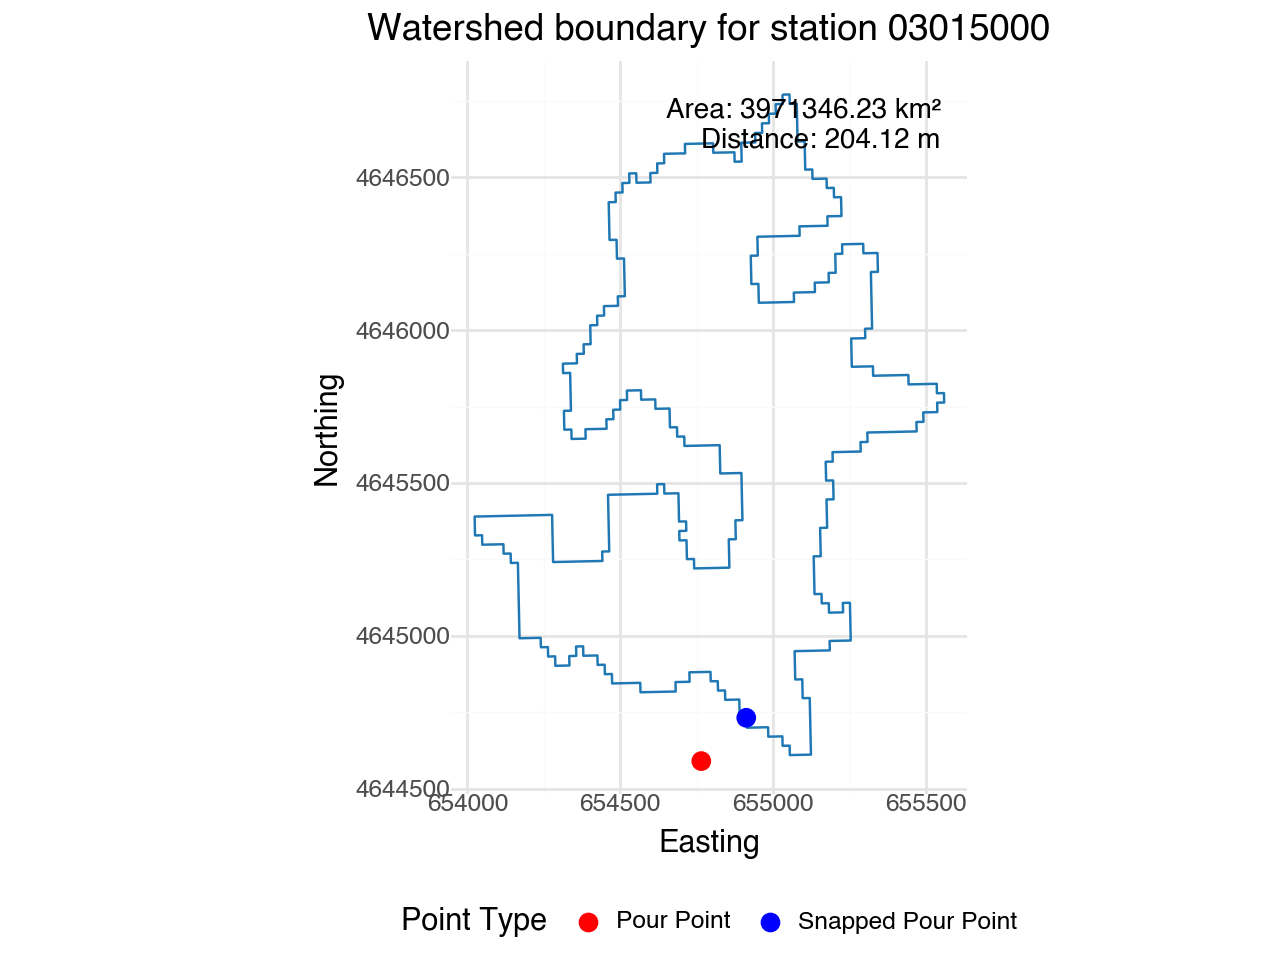

In [89]:
create_watershed_map(largest_gdf, wsb_style)